In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from keras.datasets import boston_housing

In [6]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

65536/57026 [==================================] - 0s 0us/step


In [7]:
print(train_data.shape, test_data.shape)

(404, 13) (102, 13)


In [8]:
print(train_targets.shape, test_targets.shape)

(404,) (102,)


404개의 훈련 샘플, 13개의 수치 특성이 있다. 이 특성들은 1인당 범죄율, 주택당 평균 방의 개수, 고속도로 접근성 등이다. 

타깃은 주택의 중간 가격으로 천 달러 단위이다.

일반적으로 1만에서 5만 달러 사이이다.

In [9]:
print(train_targets)

[15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4 12.1 17.9 23.1 19.9
 15.7  8.8 50.  22.5 24.1 27.5 10.9 30.8 32.9 24.  18.5 13.3 22.9 34.7
 16.6 17.5 22.3 16.1 14.9 23.1 34.9 25.  13.9 13.1 20.4 20.  15.2 24.7
 22.2 16.7 12.7 15.6 18.4 21.  30.1 15.1 18.7  9.6 31.5 24.8 19.1 22.
 14.5 11.  32.  29.4 20.3 24.4 14.6 19.5 14.1 14.3 15.6 10.5  6.3 19.3
 19.3 13.4 36.4 17.8 13.5 16.5  8.3 14.3 16.  13.4 28.6 43.5 20.2 22.
 23.  20.7 12.5 48.5 14.6 13.4 23.7 50.  21.7 39.8 38.7 22.2 34.9 22.5
 31.1 28.7 46.  41.7 21.  26.6 15.  24.4 13.3 21.2 11.7 21.7 19.4 50.
 22.8 19.7 24.7 36.2 14.2 18.9 18.3 20.6 24.6 18.2  8.7 44.  10.4 13.2
 21.2 37.  30.7 22.9 20.  19.3 31.7 32.  23.1 18.8 10.9 50.  19.6  5.
 14.4 19.8 13.8 19.6 23.9 24.5 25.  19.9 17.2 24.6 13.5 26.6 21.4 11.9
 22.6 19.6  8.5 23.7 23.1 22.4 20.5 23.6 18.4 35.2 23.1 27.9 20.6 23.7
 28.  13.6 27.1 23.6 20.6 18.2 21.7 17.1  8.4 25.3 13.8 22.2 18.4 20.7
 31.6 30.5 20.3  8.8 19.2 19.4 23.1 23.  14.8 48.8 22.6 33.4 21.1 13.6
 32.2 13.1

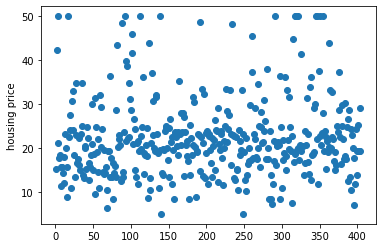

In [10]:
x = np.arange(1,len(train_targets) + 1)
plt.scatter(x, train_targets)
plt.ylabel("housing price")
plt.show()

### 데이터 준비

상이한 스케일을 가진 값을 신경망에 주입하면 문제가 된다. 네트워크가 이런 다양한 데이터에 자동으로 맞추려고 할 수 있지만 이는 학습을 어렵게 만든다. 이런 데이터를 다룰 때 대표적인 방법은 특성별로 정규화를 하는 것이다. 입력 데이터에 있는 각 특성(입력 데이터 행렬의 열)에 대해서 특성의 평균을 빼고 표준 편차로 나눈다. 특성의 중앙이 0 근처에 맞추어지고 표준 편차가 1이 된다. 넘파이를 사용하면 간단하게 할 수 있다.

In [11]:
# 데이터 정규화 <- z-score, adjusted z-score, IQR

mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

#### 테스트 데이터를 정규화할 때 사용한 값이 훈련 데이터에서 계산한(mean, std)임을 주목한다. 머신 러닝 작업 과정에서 절대로 테스트 데이터에서 계산한 어떤 값도 사용해서는 안된다.

### 모델 구성
샘플 개수가 적기 떄문에 64개의 유닛을 가진 은닉 층으로 작은 네트워크를 구성한다.

일반적으로 훈련데이터의 개수가 작을 수록 과대 적합이 더 쉽게 일어나므로 작은 모델을 사용하는 것이 과대적합을 피하는 한 방법이다.

In [44]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(13,)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

이 네트워크의 마지막 층은 하나의 유닛을 가지고 있고 활성화 함수가 없다(선형층이라 부른다). 이것이 전형적인 스칼라 회귀를 위한 구성이다. 활성화 함수를 적용하면 출력 값의 범위를 제한하게 된다. 

이 모델은 mse 손실 함수를 사용하여 컴파일한다. 이 함수는 평균 제곱 오차로 예측과 타깃 사이의 거리의 제곱이다. 

훈련하는 동안 모니터링을 위해 새로운 지표인 평균 절대 오차(MAE)를 측정한다. 이는 예측과 타깃 사이 거리의 절대값이다 예를 들어 이 예제에서 MAE가 0.5면 예측이 평균적으로 500달러 정도 차이가 난다는 뜻이다.

### K겹 검증을 사용한 훈련 검증

(훈련에 사용할 에포크 수 같은) 매개변수들을 조정하면서 모델을 평가하기 위해 데이터를 훈련 세트와 검증 세트로 나눈다. 데이터 포인트가 많지 않기 때문에 검증 세트도 매우 작아진다(약 100개), 결국 검증 세트와 훈련 세트로 어떤 데이터 포인트가 선택되었는지에 따라 검증 점수가 크게 달라진다. 검증 세트의 분할에 대한 검증 점수의 분산이 높다면 신뢰 있는 모델 평가를 할 수 없다.

이런 상황에서 가장 좋은 방법은 K겹 교차 검증을 사용하는 것이다.

데이터를 K분할(일반적으로 K=4,5) K개의 모델을 각각 만들어 K - 1개의 분할에서 훈련하고 나머지 분할에서 평가하는 방법이다. 모델의 검증 점수는 K개의 검증 점수의 평균이 된다.

In [15]:
# K겹 검증

import numpy as np

k = 4
num_val_samples = len(train_data) // k # 404//4 = 101
num_epochs = 100
all_scores = []
for i in range(k):
    print("처리중인 fold #", i)
    val_data = train_data[i * num_val_samples : (i + 1) * num_val_samples] # (0~1, 1~2, 2~3, 3~4)
    val_targets = train_targets[i * num_val_samples : (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
         axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
         axis=0)
    
    model = build_model()
    model.fit(partial_train_data, partial_train_targets, epochs=num_val_samples, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

처리중인 fold # 0
처리중인 fold # 1
처리중인 fold # 2
처리중인 fold # 3


In [18]:
all_scores

[2.110275983810425, 2.6614418029785156, 2.535376787185669, 2.468261957168579]

In [19]:
np.mean(all_scores)

2.443839132785797

평균적으로 2,475달러 정도 차이가 난다. 주택 가격의 범위가 1만 달러에서 5만 달러 사이인 것을 감안하면 비교적 큰 값이다

에폭을 500으로 늘려 신경망을 학습해본다

In [26]:
k = 4
epochs = 500
all_mae_histories = []
for i in range(k):
    print("처리중인 fold #", i)
    val_data = train_data[i * num_val_samples : (i + 1) * num_val_samples] # (0~1, 1~2, 2~3, 3~4)
    val_targets = train_targets[i * num_val_samples : (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
         axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
         axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, 
                        partial_train_targets, 
                        epochs=epochs,
                        batch_size=1,
                        validation_data=(val_data, val_targets),
                        verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

처리중인 fold # 0
처리중인 fold # 1
처리중인 fold # 2
처리중인 fold # 3


In [38]:
# k fold 점수 평균

average_mae_history = [
                       np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
]

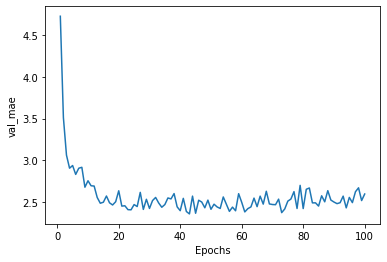

In [39]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("val_mae")
plt.show()

이 그래프는 범위가 크고 변동이 심하기 때문에 보기가 어렵다.
- 곡선의 다른 부분과 스케일이 많이 다른 첫 10개의 데이터 포인트를 제외시킨다.
- 부드러운 곡선을 얻기 위해 각 포인트를 이전 포인트의 지수이동평균(exponentioal moving average)로 대체한다.

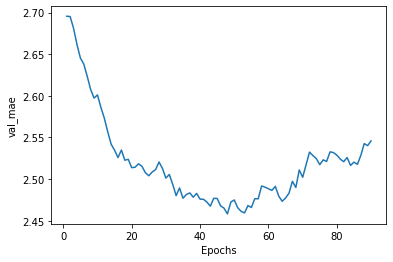

In [42]:
# 처음 10개의 데이터 포인트를 제외한 검증 점수 그리기

def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) +1), smooth_mae_history)
plt.xlabel("Epochs")
plt.ylabel("val_mae")
plt.show()

In [48]:
# 최종 모델 훈련하기
model = build_model()
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 3ms/step - loss: 18.1212 - mae: 2.7024


In [49]:
test_mae_score

2.7024004459381104